In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import pandas as pd
import numpy as np

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone

from sklearn.linear_model import Lasso, LogisticRegression

import os

%config InlineBackend.figure_formats=['retina'] 

In [3]:
lasso = Lasso(max_iter=int(1e6))
logit_lasso = LogisticRegression(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced")
en = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
    max_iter=int(1e3),
    random_state=42
)

In [4]:
preprocessing = Pipeline(
    steps=[
        ("variance_threshold", VarianceThreshold(threshold=0)),
        ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
        ("imputer", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]
)

Stabl progress: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it]
Saving issue.


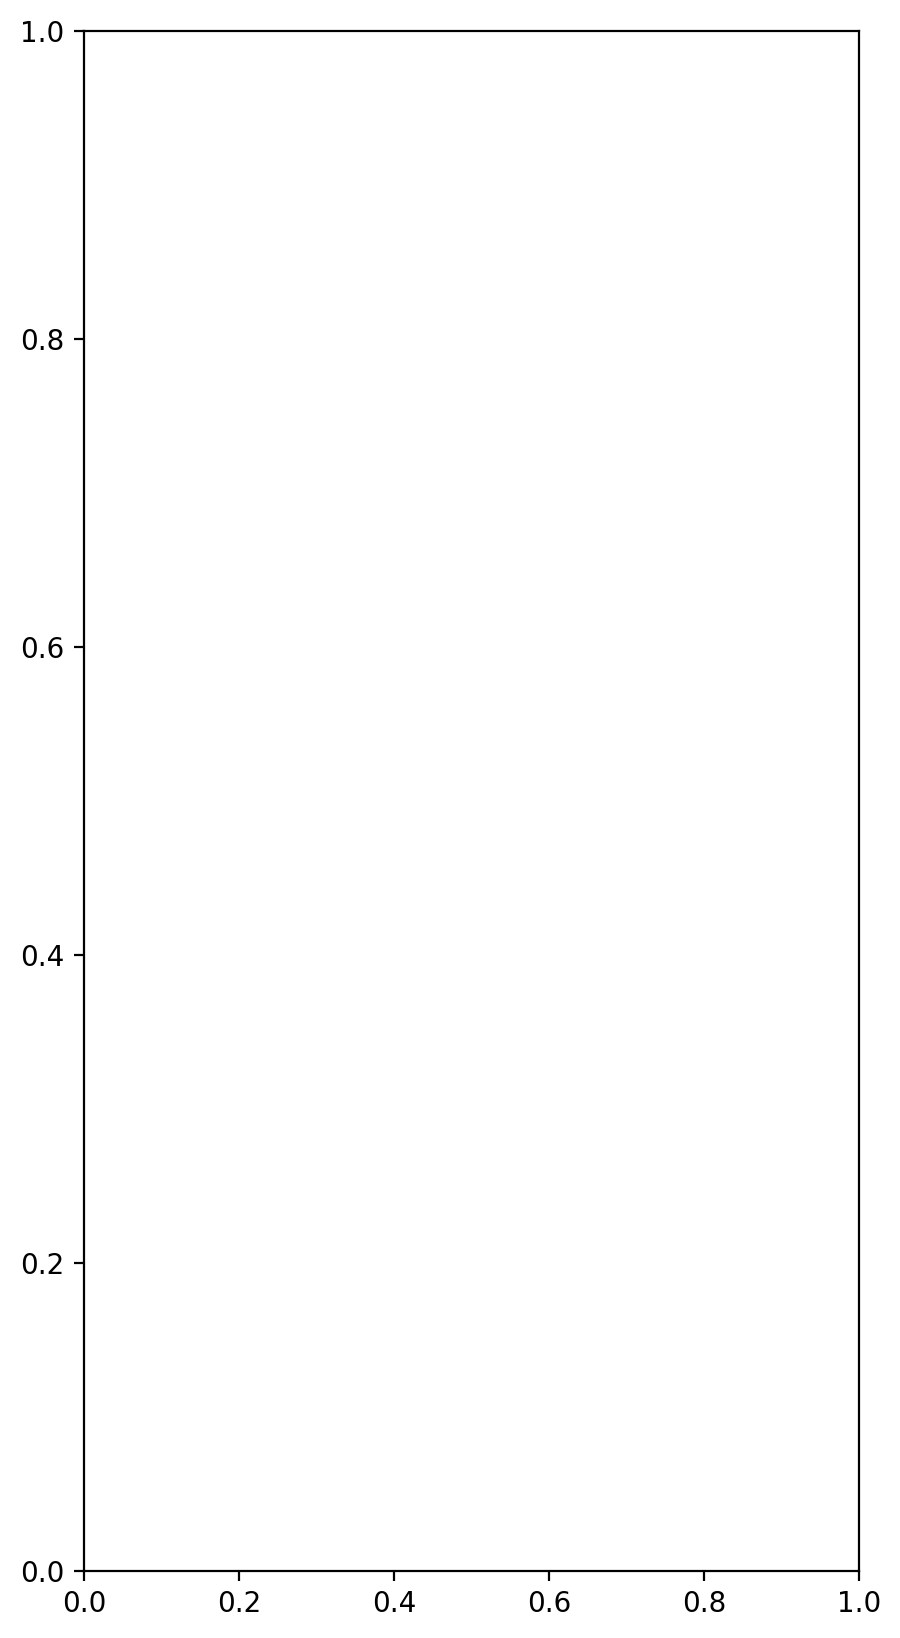

In [6]:
response = pd.read_csv("Data/Stabl/response.csv", index_col=0)
gep_neg_genes = pd.read_csv('Data/Stabl/T_Inflamed_paired_neg_genes.csv', index_col=0)

gep_neg_std = pd.DataFrame(
    data=preprocessing.fit_transform(gep_neg_genes),
    index=response.index,
    columns=preprocessing.get_feature_names_out()
)

gep_neg_lasso = Stabl(
    base_estimator=clone(logit_lasso),
    lambda_grid={"C": np.linspace(0.01, 1, 30)},
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    n_bootstraps=1000,
    random_state=42,
    verbose=1,
)

gep_neg_lasso.fit(gep_neg_std, response)

scut = 0.1
if scut > max(gep_neg_lasso.get_importances()):
    scut = max(gep_neg_lasso.get_importances())*3/4

try:
    save_stabl_results(gep_neg_lasso, 'Data/Stabl', gep_neg_std, response, new_hard_threshold=scut,
                       override=True)
except:
    print("Saving issue.")